In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#connect to poloniex public api
polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1356998100&end=9999999999&period=86400'
eth_df = pd.read_json(polo_url)
eth_df = eth_df.set_index('date')

In [3]:
eth_df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08,1.40,1.85,0.500000,1.65,176.539438,274.003968,1.552084
2015-08-09,1.40,1.40,1.400000,1.40,0.000000,0.000000,1.400000
2015-08-10,1.40,1.40,1.400000,1.40,0.000000,0.000000,1.400000
2015-08-11,1.10,1.14,0.550000,0.66,251.517082,242.975973,0.966042
2015-08-12,1.38,1.40,0.900001,1.05,404.344781,476.807211,1.179210


In [4]:
eth_df.describe()

,close,high,low,open,quoteVolume,volume,weightedAverage
count,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1.290000e+03,1290.000000
mean,205.933246,214.827492,194.903280,205.805123,24445.728085,5.596792e+06,204.968755
std,267.686735,280.452059,251.660443,267.687014,43844.631645,1.135606e+07,266.275961
min,0.429691,0.465220,0.005000,0.429691,0.000000,0.000000e+00,0.439825
25%,10.415036,10.695990,9.850000,10.363400,3110.680770,4.596553e+04,10.328703
50%,88.996939,91.909965,84.905399,88.756247,8401.482771,8.345113e+05,89.240498
75%,305.798759,317.657203,293.075000,306.126502,27356.027993,5.304180e+06,304.226801
max,1382.000000,1424.000000,1264.000000,1382.000000,427541.821839,9.151612e+07,1354.371792


In [5]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2015-08-08 to 2019-02-17
Data columns (total 7 columns):
close              1290 non-null float64
high               1290 non-null float64
low                1290 non-null float64
open               1290 non-null float64
quoteVolume        1290 non-null float64
volume             1290 non-null float64
weightedAverage    1290 non-null float64
dtypes: float64(7)
memory usage: 80.6 KB


In [6]:
#discard and define new data
eth_df['hi_lo_pct'] = (eth_df['high'] - eth_df['low'])/(eth_df['low']*100)
eth_df['pct_change'] = (eth_df['close'] - eth_df['open'])/(eth_df['open']*100)
eth_df = eth_df[['close', 'hi_lo_pct', 'pct_change', 'volume']]
eth_df.tail()

,close,hi_lo_pct,pct_change,volume
date,,,,
2019-02-13,122.042960,0.000428,-0.000033,474319.172751
2019-02-14,120.350000,0.000346,-0.000135,332297.772423
2019-02-15,121.424776,0.000333,0.000085,314876.166339
2019-02-16,122.843760,0.000269,0.000123,326512.503403
2019-02-17,129.395100,0.000601,0.000541,610276.883418


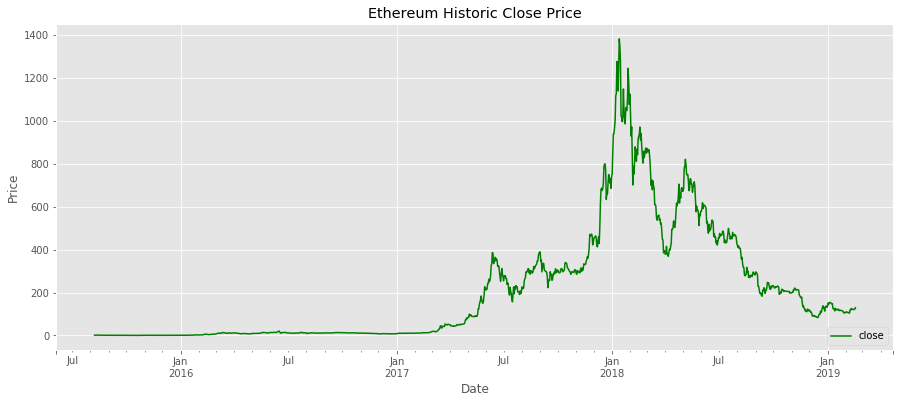

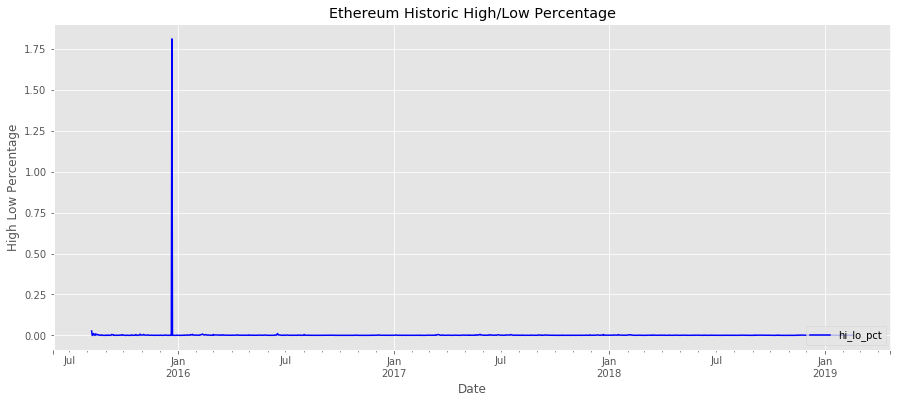

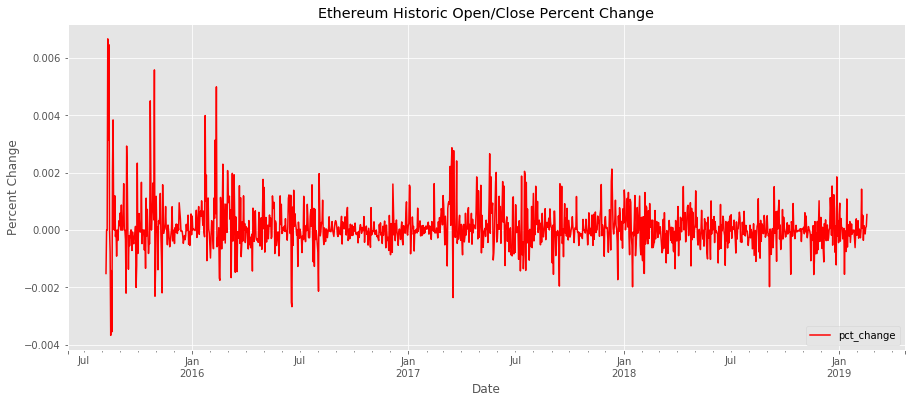

In [7]:
#visualize
eth_df['close'].plot(figsize=(15,6), color='green')
plt.legend(loc=4)
plt.title('Ethereum Historic Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
eth_df['hi_lo_pct'].plot(figsize=(15,6), color='blue')
plt.title('Ethereum Historic High/Low Percentage')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()
eth_df['pct_change'].plot(figsize=(15,6), color='red')
plt.title('Ethereum Historic Open/Close Percent Change')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

In [8]:
eth_df.describe()

,close,hi_lo_pct,pct_change,volume
count,1290.000000,1290.000000,1290.000000,1.290000e+03
mean,205.933246,0.002500,0.000076,5.596792e+06
std,267.686735,0.050437,0.000784,1.135606e+07
min,0.429691,0.000000,-0.003672,0.000000e+00
25%,10.415036,0.000446,-0.000257,4.596553e+04
50%,88.996939,0.000758,0.000000,8.345113e+05
75%,305.798759,0.001329,0.000326,5.304180e+06
max,1382.000000,1.811997,0.006667,9.151612e+07


In [9]:
#remove outliers with IQR
def remove_outlier(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)

  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)

  out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return out_df


In [10]:
eth_df = remove_outlier(eth_df, 'hi_lo_pct')
eth_df = remove_outlier(eth_df, 'pct_change')
eth_df.describe()

,close,hi_lo_pct,pct_change,volume
count,1115.000000,1115.000000,1115.000000,1.115000e+03
mean,210.750630,0.000776,0.000007,4.385759e+06
std,265.374708,0.000496,0.000407,8.114889e+06
min,0.429691,0.000000,-0.001023,0.000000e+00
25%,10.637658,0.000406,-0.000237,4.971948e+04
50%,98.400000,0.000666,-0.000011,7.940048e+05
75%,314.030000,0.001043,0.000237,4.517350e+06
max,1382.000000,0.002647,0.001092,6.927351e+07


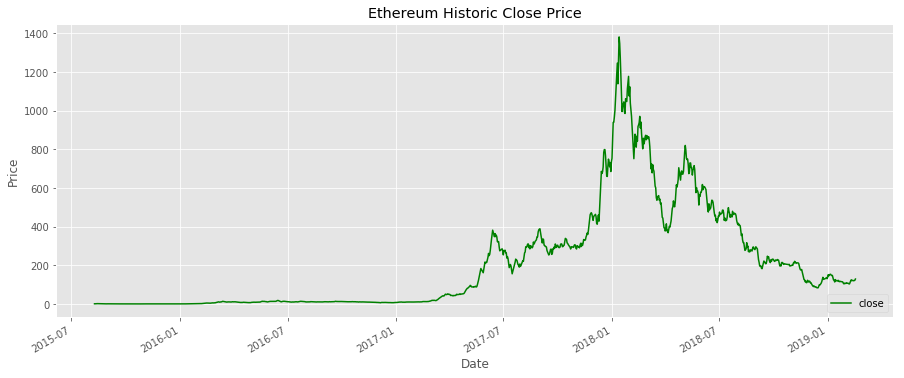

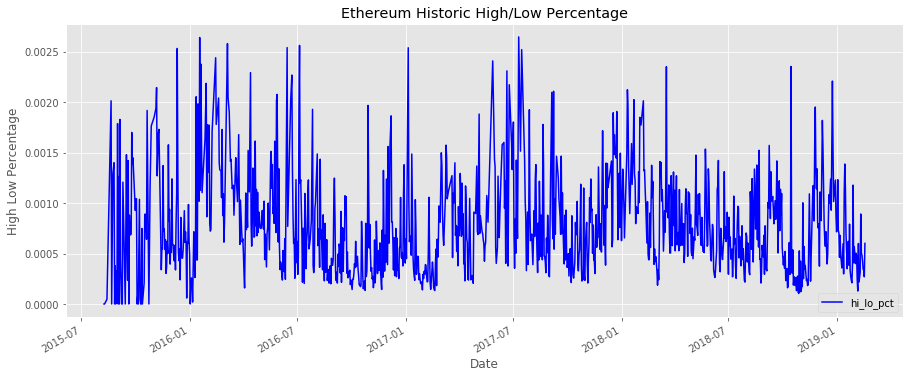

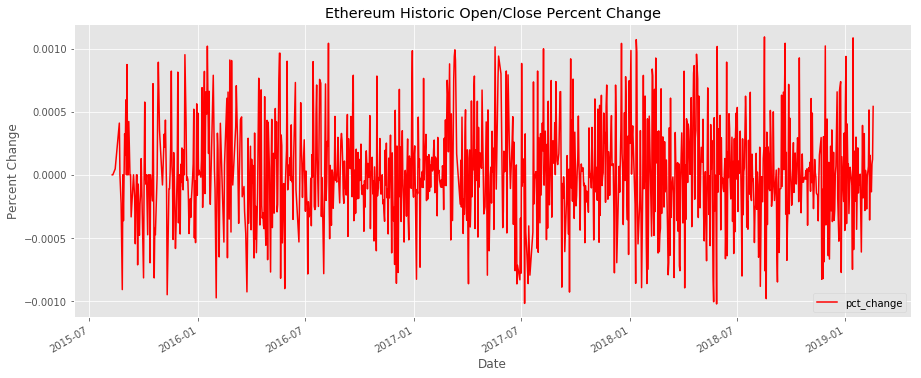

In [11]:
#visualize
eth_df['close'].plot(figsize=(15,6), color='green')
plt.legend(loc=4)
plt.title('Ethereum Historic Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
eth_df['hi_lo_pct'].plot(figsize=(15,6), color='blue')
plt.title('Ethereum Historic High/Low Percentage')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()
eth_df['pct_change'].plot(figsize=(15,6), color='red')
plt.title('Ethereum Historic Open/Close Percent Change')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

In [12]:
#create forcast column
forecast_col = 'close'
#forecast 30 days ahead
forecast_out = int(30)
print('length =',len(eth_df), "and forecast_out =", forecast_out)

length = 1115 and forecast_out = 30


In [13]:
#create output column
eth_df['label'] = eth_df[forecast_col].shift(-forecast_out)

In [14]:
# standardize data 
X = np.array(eth_df.drop(['label'],1))
X = preprocessing.scale(X)
print(X[1,:])

[-0.7892409  -1.56730533 -0.01766925 -0.54070079]


In [15]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 30 & Length of X : 1085


In [16]:
# define Label vector y for the data we have prediction for
y = np.array(eth_df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

Length of y:  1085


In [17]:
# cross validation split into test and train data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

In [18]:
print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  868 217


In [19]:
# train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
#show accuracy of model on test data
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.7160253175368283


In [20]:
# predict
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[119.2349121  118.97721402 113.84524995 117.96930604 110.41773389
 117.20824692 120.10206224 122.83824457 120.72791183 113.81347613
  90.18335549 108.88899369 112.61591617 107.63705472 111.23801192
 110.53057604 105.83946841 114.71687386 116.4080954  104.47528057
 113.44544447 125.87994584 114.01365057 116.5561254  121.28460364
 121.29971856 120.42693268 122.62548392 125.82548293 125.93367164]


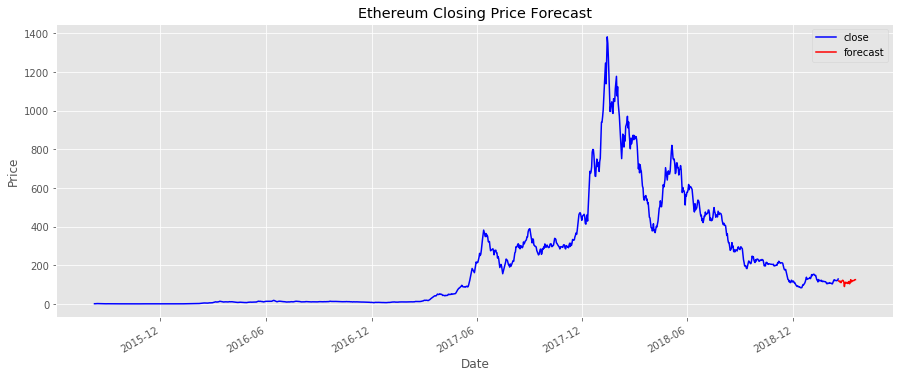

In [21]:
#add predicted dates to df
eth_df['forecast'] = np.nan
last_date = eth_df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    eth_df.loc[next_date] = [np.nan for _ in range(len(eth_df.columns)-1)]+[i]
    
# Plot data    
eth_df['close'].plot(figsize=(15,6), color="blue")
eth_df['forecast'].plot(figsize=(15,6), color="red")
plt.legend(loc=1)
plt.title("Ethereum Closing Price Forecast")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

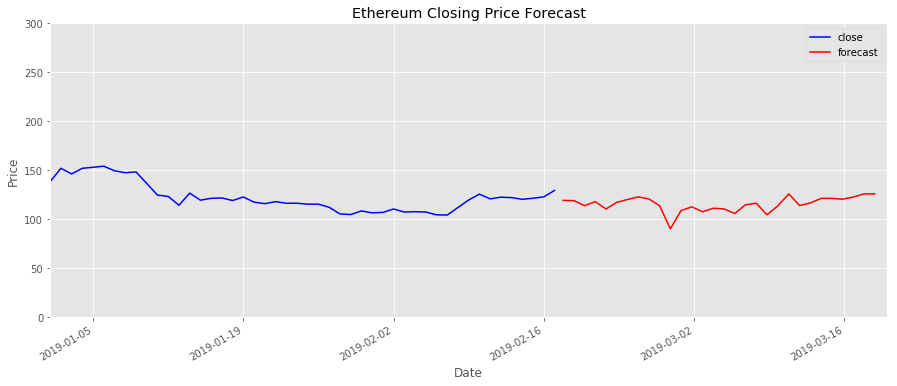

In [24]:
#zoom in on forecast
eth_df['close'].plot(figsize=(15,6), color="blue")
eth_df['forecast'].plot(figsize=(15,6), color="red")
plt.xlim(xmin=datetime.date(2019, 1, 1), xmax = datetime.date(2019, 3, 20) )
plt.ylim(ymin=0, ymax=300)
plt.legend(loc=1)
plt.title("Ethereum Closing Price Forecast")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [25]:
print('Price for last 5 days:')
print(eth_df['close'][-35:-30])
print('Price for next 5 days')
print(eth_df['forecast'][-30:-25])

Price for last 5 days:
date
2019-02-13    122.042960
2019-02-14    120.350000
2019-02-15    121.424776
2019-02-16    122.843760
2019-02-17    129.395100
Name: close, dtype: float64
Price for next 5 days
date
2019-02-17 19:00:00    119.234912
2019-02-18 19:00:00    118.977214
2019-02-19 19:00:00    113.845250
2019-02-20 19:00:00    117.969306
2019-02-21 19:00:00    110.417734
Name: forecast, dtype: float64
